#Sequencing Success: A Hands-On Workshop in Deep Learning for Sequence-to-Sequence Models
Moratuwa Engineering Research Conference 2023 (MERCon 2023) is the 9th international conference organized by the Engineering Research Unit at the University of Moratuwa. As part of MERCon 2023, we are hosting a Hands-On Workshop on Deep Learning for Sequence-to-Sequence Models. This workshop spans four hours and is divided into four one-hour sessions, covering the following topics:
- Introduction to Sequence-to-Sequence Learning
- Sequence-to-Sequence Learning with Recurrent Neural Networks (RNNs)
- Sequence-to-Sequence Learning with Encoder-Decoder Models
- Sequence-to-Sequence Learning with Encoder-Decoder Models and Attention Mechanisms

This notebook is prepared for session **Sequence-to-Sequence Learning with Recurrent Neural Networks**.

All rights reserved.

Authors:
1.   Dr.T.Uthayasanker ([rtuthaya.lk](https://rtuthaya.lk))
2.   Mr.S.Braveenan

[For more information - MERCon 2023](https://mercon.uom.lk)

#A Simple Seq2Seq Problem 2: The reverse sentence problem
In this simple Seq2Seq problem, we are provided with a **parallel dataset** comprising two sentences, X (input) and y (output). In this scenario, the output sentence, y[i], is constructed by reversing the order of the words in the input sentence, X[i]. To illustrate, consider an example where the **input sentence X[i]** has a length of 6, such as:

X[i] = **he ate apple**

The corresponding **output sentence, y[i]**, would be:

y[i] = **apple ate he**

This problem serves as a foundational example of a Sequence-to-Sequence (Seq2Seq) task, where the objective is to learn to reverse sentences effectively.

In [1]:
#@title Import Libraries
import random
import numpy as np
import matplotlib.pyplot as plt

from keras import Input
from keras.layers import RepeatVector, Dense, SimpleRNN, GRU, LSTM, TimeDistributed
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from keras.models import Sequential, Model

#Auxiliary functions

Certainly! Here's a more concise introduction to the key functions in the code snippet:
1. **generate_text_sequence(length, word_array)**: Generates a random text sequence of a given length using words from an array.
2. **one_hot_encode_text(text_sequence, word_array)**: Converts a text sequence into one-hot encoded vectors using a word array.
3. **one_hot_decode_text(encoded_seq, word_array)**: Decodes a one-hot encoded sequence back into its original text form.
4. **get_reversed_pairs(time_steps, word_array, verbose=False)**: Generates pairs of random sequences and their reversals, one-hot encodes them, and returns them for training.
5. **create_dataset(train_size, test_size, time_steps, word_array, verbose=False)**: Creates training and testing datasets by generating reversed pairs.
6. **train_test(model, X_train, y_train, X_test, y_test, epochs=100, verbose=0)**: Trains a neural network model, evaluates it, and returns the model and training history.
7. **visualize_history(history)**: Visualizes the training history, showing accuracy and loss over epochs.
8. **check_samples(model, X_test, y_test, word_array, num_samples=10)**: Checks the model's performance on a set of sample sequences from the testing data.

These functions collectively support the process of training and evaluating a neural network for a sentence reversal task.

In [2]:
#@title Function to generate a text sequence
# generate sequence
def generate_text_sequence(length, word_array):
    word_sequence = [random.choice(word_array) for _ in range(length)]
    text_sequence = ' '.join(word_sequence)
    return text_sequence

In [3]:
#@title Function to encode and decode text sequence
# one hot encode sequence
def one_hot_encode_text(text_sequence, word_array):
    encoding = []
    for word in text_sequence.split():
        vector = [0] * len(word_array)
        if word in word_array:
            vector[word_array.index(word)] = 1
        encoding.append(vector)
    return np.array(encoding)

# decode a one hot encoded string
def one_hot_decode_text(encoded_seq, word_array):
    decoded_sequence = [word_array[np.argmax(vector)] for vector in encoded_seq]
    return ' '.join(decoded_sequence)

In [4]:
#@title Function to generate reverse pair dataset
# create one reverse pair
def get_reversed_pairs(time_steps,word_array,verbose= False):
		# generate random sequence
		sequence_in = generate_text_sequence(time_steps, word_array)
		sequence_out = ' '.join(sequence_in.split()[::-1])

		# one hot encode
		X = one_hot_encode_text(sequence_in, word_array)
		y = one_hot_encode_text(sequence_out, word_array)
		# reshape as 3D
		X = X.reshape((1, X.shape[0], X.shape[1]))
		y = y.reshape((1, y.shape[0], y.shape[1]))

		if(verbose):
			print('\nSample X and y')
			print('\nIn raw format:')
			print('X[0]=%s, y[0]=%s' % (one_hot_decode_text(X[0], word_array), one_hot_decode_text(y[0], word_array)))
			print('\nIn one_hot_encoded format:')
			print('X[0]=%s' % (X[0]))
			print('y[0]=%s' % (y[0]))
		return X,y

# create final dataset
def create_dataset(train_size, test_size, time_steps,word_array, verbose= False):
		pairs = [get_reversed_pairs(time_steps,word_array) for _ in range(train_size)]
		pairs=np.array(pairs).squeeze()
		X_train = pairs[:,0]
		y_train = pairs[:,1]
		pairs = [get_reversed_pairs(time_steps,word_array) for _ in range(test_size)]
		pairs=np.array(pairs).squeeze()
		X_test = pairs[:,0]
		y_test = pairs[:,1]

		if(verbose):
			print('\nGenerated sequence datasets as follows')
			print('X_train.shape: ', X_train.shape,'y_train.shape: ', y_train.shape)
			print('X_test.shape: ', X_test.shape,'y_test.shape: ', y_test.shape)

		return X_train, y_train, X_test, 	y_test

In [5]:
#@title Function to train and evaluate model
def train_test(model, X_train, y_train , X_test, y_test, epochs=100, verbose=0):
    # patient early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

    # train model
    print('training for ',epochs,' epochs begins with validation_split= 0.1 & EarlyStopping(monitor= val_loss, patience=20)....')
    history = model.fit(X_train, y_train, validation_split=0.1, epochs=epochs, verbose=verbose, callbacks=[es])
    print(epochs,' epoch training finished...')

    # evaluate the model
    _, train_acc = model.evaluate(X_train, y_train, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, verbose=0)

    print('\nPREDICTION ACCURACY (%):')
    print('Train: %.3f, Test: %.3f' % (train_acc*100, test_acc*100))

    return model, history.history

In [6]:
#@title Function to visualize loss and accuracy
def visualize_history(history):
	# summarize history for accuracy
	plt.plot(history['accuracy'])
	plt.plot(history['val_accuracy'])
	plt.ylabel('accuracy')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()
	# summarize history for loss
	plt.plot(history['loss'])
	plt.plot(history['val_loss'])
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()

In [7]:
#@title Function to check some examples
def check_samples(model, X_test, y_test, word_array, num_samples=10):
    sample_indices = random.sample(range(len(X_test)), num_samples)

    for id in sample_indices:
        X, y = X_test[id], y_test[id]
        X = np.expand_dims(X, axis=0)
        y = np.expand_dims(y, axis=0)
        yhat = model.predict(X, verbose=0)
        print(f"Input: {one_hot_decode_text(X[0], word_array)} \nExpected: {one_hot_decode_text(y[0], word_array)} \nPredicted: {one_hot_decode_text(yhat[0], word_array)} \n{np.array_equal(one_hot_decode_text(y[0], word_array), one_hot_decode_text(yhat[0], word_array))}\n")

#Create reverse sentence dataset


This code snippet is designed to generate a dataset for the **Reverse Sentence Task**. In this task, each data point consists of a sentence and its reversed counterpart. The essential parameters include the input sequence length (n_timesteps_in), the number of unique words (n_features), the size of the training dataset (train_size), and the size of the testing dataset (test_size).

The code accomplishes the following:
1. It generates a random sentence and its reversed version, one-hot encodes them, and optionally displays sample pairs of sentences to illustrate the dataset structure.
2. The code then creates training and testing datasets by generating pairs of random sentences and their reversals. The dataset sizes are determined by the parameters train_size and test_size.

This dataset is a crucial component for training and evaluating models for the **Reverse Sentence Task**, which is a common problem in natural language processing.

In [8]:
word_array = ["apple", "banana", "cherry", "orange", "strawberry",
             "carrot", "broccoli", "potato", "tomato", "cucumber",
             "rose", "tulip", "daisy", "lily", "sunflower",
             "red", "blue", "green", "yellow", "purple",
             "Colombo", "London", "Paris", "Tokyo", "Sydney",
             "car", "bus", "bicycle", "train", "motorcycle",
             "guitar", "piano", "violin", "trumpet", "flute",
             "beach", "mountain", "park", "desert", "island",
             "book", "computer", "chair", "table", "lamp",
             "dog", "cat", "bird", "elephant", "lion"]

In [9]:
#@title Generating dataset
# Default configuration parameters
n_timesteps_in = 6
n_features = len(word_array)
train_size = 20000
test_size = 200

# Generate random sequence using specified parameters
X, y = get_reversed_pairs(n_timesteps_in, word_array, verbose=True)

# Generate datasets using specified parameters
X_train, y_train, X_test, y_test = create_dataset(train_size, test_size, n_timesteps_in, word_array, verbose=True)


Sample X and y

In raw format:
X[0]=tulip dog purple cucumber rose park, y[0]=park rose cucumber purple dog tulip

In one_hot_encoded format:
X[0]=[[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 1 0 0 0 0 0 0 0 0 0 0 0 0]]
y[0]=[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 

#1. Multi-Layer Perceptron network model

Model: "model_Multi_Layer_Perceptron"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6, 128)            6528      
                                                                 
 dense_1 (Dense)             (None, 6, 64)             8256      
                                                                 
 dense_2 (Dense)             (None, 6, 50)             3250      
                                                                 
Total params: 18034 (70.45 KB)
Trainable params: 18034 (70.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


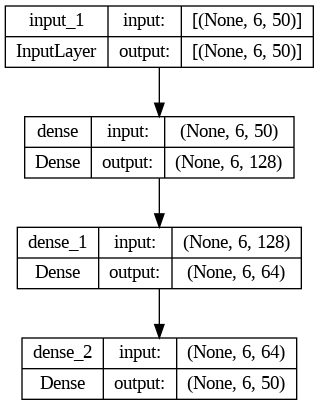

In [10]:
#@title Create Multi-Layer Perceptron network model
numberOfPerceptrons=64
model_Multi_Layer_Perceptron = Sequential(name='model_Multi_Layer_Perceptron')
model_Multi_Layer_Perceptron.add(Input(shape=(n_timesteps_in, n_features)))
model_Multi_Layer_Perceptron.add(Dense(2*numberOfPerceptrons))
model_Multi_Layer_Perceptron.add(Dense(numberOfPerceptrons))
model_Multi_Layer_Perceptron.add(Dense(n_features, activation='softmax'))

model_Multi_Layer_Perceptron.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_Multi_Layer_Perceptron.summary()
plot_model(model_Multi_Layer_Perceptron,show_shapes=True)

In [11]:
#@title Train and Evaluate Multi-Layer Perceptron network model
trained_model_mlp, history_mlp = train_test(model_Multi_Layer_Perceptron, X_train, y_train , X_test, y_test, verbose=2)

training for  100  epochs begins with validation_split= 0.1 & EarlyStopping(monitor= val_loss, patience=20)....
Epoch 1/100
563/563 - 6s - loss: 3.9180 - accuracy: 0.0198 - val_loss: 3.9165 - val_accuracy: 0.0203 - 6s/epoch - 11ms/step
Epoch 2/100
563/563 - 4s - loss: 3.9116 - accuracy: 0.0226 - val_loss: 3.9176 - val_accuracy: 0.0197 - 4s/epoch - 8ms/step
Epoch 3/100
563/563 - 3s - loss: 3.9101 - accuracy: 0.0230 - val_loss: 3.9187 - val_accuracy: 0.0215 - 3s/epoch - 5ms/step
Epoch 4/100
563/563 - 3s - loss: 3.9094 - accuracy: 0.0241 - val_loss: 3.9191 - val_accuracy: 0.0203 - 3s/epoch - 6ms/step
Epoch 5/100
563/563 - 5s - loss: 3.9087 - accuracy: 0.0238 - val_loss: 3.9196 - val_accuracy: 0.0203 - 5s/epoch - 8ms/step
Epoch 6/100
563/563 - 3s - loss: 3.9083 - accuracy: 0.0244 - val_loss: 3.9197 - val_accuracy: 0.0186 - 3s/epoch - 5ms/step
Epoch 7/100
563/563 - 2s - loss: 3.9080 - accuracy: 0.0244 - val_loss: 3.9206 - val_accuracy: 0.0188 - 2s/epoch - 3ms/step
Epoch 8/100
563/563 - 2s -

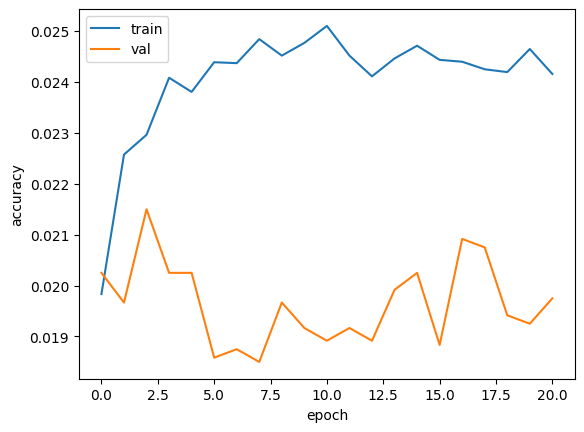

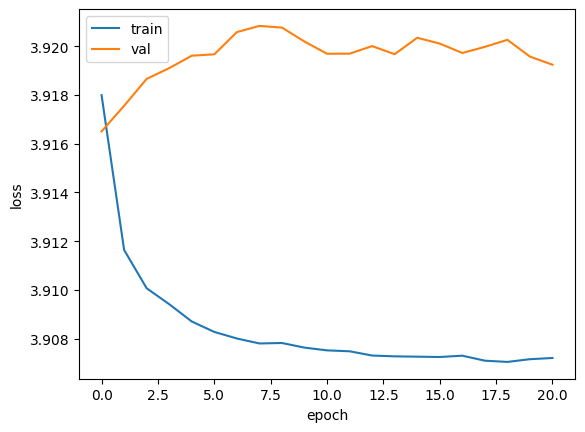

In [12]:
#@title Visualize training and validation Multi-Layer Perceptron network model
visualize_history(history_mlp)

In [13]:
#@title Check random samples Multi-Layer Perceptron network model
check_samples(trained_model_mlp, X_test, y_test, word_array, num_samples=10)

Input: car book lion flute blue broccoli 
Expected: broccoli blue flute lion book car 
Predicted: bird tomato desert broccoli book broccoli 
False

Input: violin lily chair cucumber book London 
Expected: London book cucumber chair lily violin 
Predicted: mountain London yellow banana tomato lily 
False

Input: apple Paris car orange flute car 
Expected: car flute orange car Paris apple 
Predicted: broccoli banana bird flute broccoli bird 
False

Input: trumpet flute Sydney Sydney bus carrot 
Expected: carrot bus Sydney Sydney flute trumpet 
Predicted: island broccoli computer computer Paris tulip 
False

Input: island red bird rose purple tomato 
Expected: tomato purple rose bird red island 
Predicted: lamp sunflower elephant tomato banana broccoli 
False

Input: beach lamp red desert book island 
Expected: island book desert red lamp beach 
Predicted: yellow island sunflower computer tomato lamp 
False

Input: tomato rose cucumber island cat rose 
Expected: rose cat island cucumber r

#2. Recurrent Neural Networks

#2.1. Simple Recurrent Neural Network model (RNN)

Model: "model_RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 6, 64)             7360      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 6, 64)             8256      
                                                                 
 time_distributed (TimeDist  (None, 6, 50)             3250      
 ributed)                                                        
                                                                 
Total params: 18866 (73.70 KB)
Trainable params: 18866 (73.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


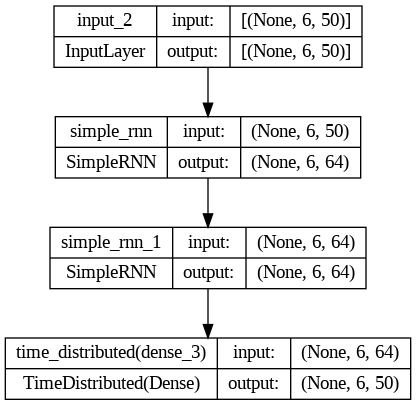

In [14]:
#@title Create simple RNN model
numberOfUnits = 64
model_RNN = Sequential(name='model_RNN')
model_RNN.add(Input(shape=(n_timesteps_in, n_features)))
model_RNN.add(SimpleRNN(numberOfUnits, return_sequences=True))
model_RNN.add(SimpleRNN(numberOfUnits, return_sequences=True))
model_RNN.add(TimeDistributed(Dense(n_features, activation='softmax')))

model_RNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_RNN.summary()
plot_model(model_RNN, show_shapes=True)

In [15]:
#@title Train and Evaluate simple RNN model
trained_model_rnn, history_rnn = train_test(model_RNN, X_train, y_train , X_test, y_test, verbose=2)

training for  100  epochs begins with validation_split= 0.1 & EarlyStopping(monitor= val_loss, patience=20)....
Epoch 1/100
563/563 - 6s - loss: 3.1076 - accuracy: 0.2692 - val_loss: 2.8318 - val_accuracy: 0.3278 - 6s/epoch - 11ms/step
Epoch 2/100
563/563 - 3s - loss: 2.7430 - accuracy: 0.3348 - val_loss: 2.7270 - val_accuracy: 0.3347 - 3s/epoch - 5ms/step
Epoch 3/100
563/563 - 3s - loss: 2.6664 - accuracy: 0.3397 - val_loss: 2.6758 - val_accuracy: 0.3392 - 3s/epoch - 5ms/step
Epoch 4/100
563/563 - 4s - loss: 2.6303 - accuracy: 0.3409 - val_loss: 2.6556 - val_accuracy: 0.3392 - 4s/epoch - 7ms/step
Epoch 5/100
563/563 - 3s - loss: 2.6078 - accuracy: 0.3420 - val_loss: 2.6369 - val_accuracy: 0.3377 - 3s/epoch - 5ms/step
Epoch 6/100
563/563 - 3s - loss: 2.5924 - accuracy: 0.3427 - val_loss: 2.6284 - val_accuracy: 0.3392 - 3s/epoch - 5ms/step
Epoch 7/100
563/563 - 3s - loss: 2.5817 - accuracy: 0.3423 - val_loss: 2.6207 - val_accuracy: 0.3391 - 3s/epoch - 6ms/step
Epoch 8/100
563/563 - 4s -

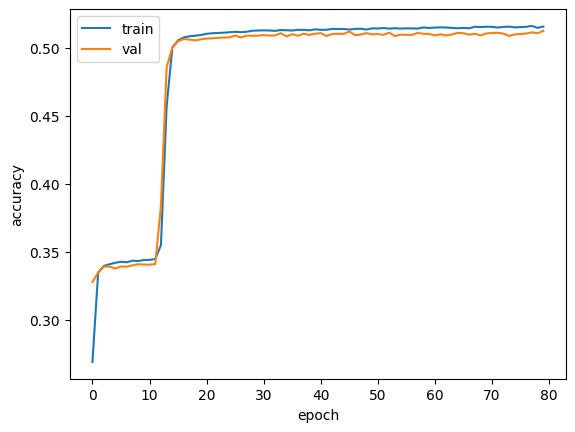

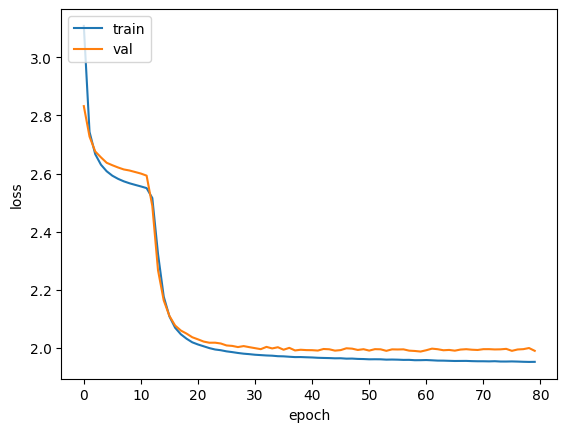

In [16]:
#@title Visualize training and validation simple RNN model
visualize_history(history_rnn)

In [17]:
#@title Check random samples simple RNN model
check_samples(trained_model_rnn, X_test, y_test, word_array, num_samples=10)

Input: elephant cucumber flute apple daisy cherry 
Expected: cherry daisy apple flute cucumber elephant 
Predicted: beach piano cucumber flute cucumber elephant 
False

Input: London trumpet Colombo apple banana blue 
Expected: blue banana apple Colombo trumpet London 
Predicted: banana chair red Colombo trumpet London 
False

Input: violin green cat lily lily banana 
Expected: banana lily lily cat green violin 
Predicted: train London motorcycle cat green violin 
False

Input: Sydney car rose green violin table 
Expected: table violin green rose car Sydney 
Predicted: blue motorcycle Paris rose car Sydney 
False

Input: sunflower red dog violin lion tulip 
Expected: tulip lion violin dog red sunflower 
Predicted: table motorcycle bicycle dog red sunflower 
False

Input: cat broccoli park Tokyo cherry cherry 
Expected: cherry cherry Tokyo park broccoli cat 
Predicted: motorcycle cat green park broccoli cat 
False

Input: banana banana Paris park flute elephant 
Expected: elephant flute

#2.2. Gated Recurrent Units model (GRU)

Model: "model_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 6, 64)             22272     
                                                                 
 gru_1 (GRU)                 (None, 6, 64)             24960     
                                                                 
 time_distributed_1 (TimeDi  (None, 6, 50)             3250      
 stributed)                                                      
                                                                 
Total params: 50482 (197.20 KB)
Trainable params: 50482 (197.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


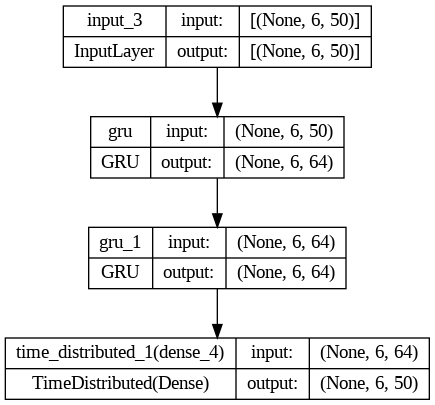

In [18]:
#@title Create GRU model
numberOfUnits = 64
model_GRU = Sequential(name='model_GRU')
model_GRU.add(Input(shape=(n_timesteps_in, n_features)))
model_GRU.add(GRU(numberOfUnits, return_sequences=True))
model_GRU.add(GRU(numberOfUnits, return_sequences=True))
model_GRU.add(TimeDistributed(Dense(n_features, activation='softmax')))

model_GRU.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_GRU.summary()
plot_model(model_GRU, show_shapes=True)

In [19]:
#@title Train and Evaluate GRU model
trained_model_gru, history_gru = train_test(model_GRU, X_train, y_train , X_test, y_test, verbose=2)

training for  100  epochs begins with validation_split= 0.1 & EarlyStopping(monitor= val_loss, patience=20)....
Epoch 1/100
563/563 - 11s - loss: 3.3051 - accuracy: 0.1418 - val_loss: 2.9793 - val_accuracy: 0.1795 - 11s/epoch - 20ms/step
Epoch 2/100
563/563 - 6s - loss: 2.8769 - accuracy: 0.1918 - val_loss: 2.8037 - val_accuracy: 0.2011 - 6s/epoch - 11ms/step
Epoch 3/100
563/563 - 7s - loss: 2.6406 - accuracy: 0.2840 - val_loss: 2.4783 - val_accuracy: 0.3727 - 7s/epoch - 12ms/step
Epoch 4/100
563/563 - 6s - loss: 2.3445 - accuracy: 0.4197 - val_loss: 2.2635 - val_accuracy: 0.4518 - 6s/epoch - 11ms/step
Epoch 5/100
563/563 - 8s - loss: 2.1709 - accuracy: 0.4766 - val_loss: 2.1366 - val_accuracy: 0.4842 - 8s/epoch - 14ms/step
Epoch 6/100
563/563 - 6s - loss: 2.0747 - accuracy: 0.4978 - val_loss: 2.0581 - val_accuracy: 0.4994 - 6s/epoch - 10ms/step
Epoch 7/100
563/563 - 7s - loss: 2.0232 - accuracy: 0.5056 - val_loss: 2.0206 - val_accuracy: 0.5048 - 7s/epoch - 12ms/step
Epoch 8/100
563/56

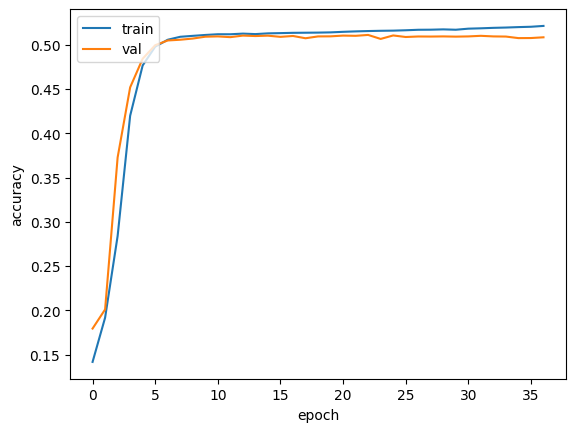

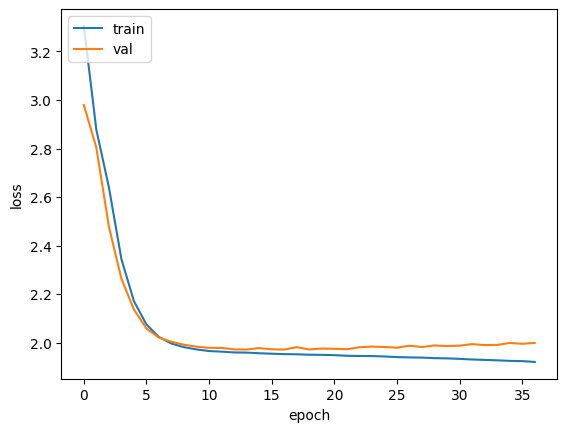

In [20]:
#@title Visualize training and validation GRU model
visualize_history(history_gru)

In [21]:
#@title Check random samples GRU model
check_samples(trained_model_gru, X_test, y_test, word_array, num_samples=10)

Input: dog blue carrot piano motorcycle lily 
Expected: lily motorcycle piano carrot blue dog 
Predicted: book purple chair carrot blue dog 
False

Input: carrot purple computer bird blue banana 
Expected: banana blue bird computer purple carrot 
Predicted: carrot banana violin computer purple carrot 
False

Input: beach lamp London computer flute red 
Expected: red flute computer London lamp beach 
Predicted: elephant book computer London lamp beach 
False

Input: strawberry Tokyo Colombo chair yellow piano 
Expected: piano yellow chair Colombo Tokyo strawberry 
Predicted: cherry bicycle strawberry Colombo Tokyo strawberry 
False

Input: train green carrot Paris park purple 
Expected: purple park Paris carrot green train 
Predicted: dog train bus carrot green train 
False

Input: Tokyo banana island Tokyo guitar beach 
Expected: beach guitar Tokyo island banana Tokyo 
Predicted: banana broccoli dog island banana Tokyo 
False

Input: park bird guitar orange guitar potato 
Expected: pot

#2.3. Long Short-Term Memory model (LSTM)



Model: "model_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 64)             29440     
                                                                 
 lstm_1 (LSTM)               (None, 6, 64)             33024     
                                                                 
 time_distributed_2 (TimeDi  (None, 6, 50)             3250      
 stributed)                                                      
                                                                 
Total params: 65714 (256.70 KB)
Trainable params: 65714 (256.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


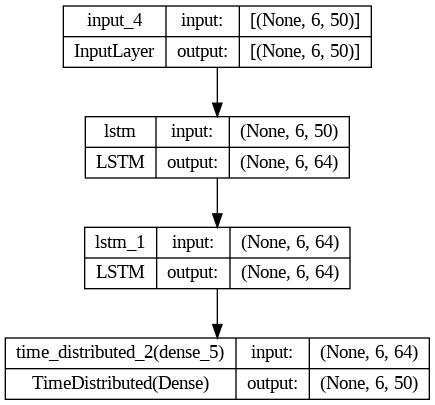

In [22]:
#@title Create LSTM model
numberOfUnits = 64
model_LSTM = Sequential(name='model_LSTM')
model_LSTM.add(Input(shape=(n_timesteps_in, n_features)))
model_LSTM.add(LSTM(numberOfUnits,return_sequences=True))
model_LSTM.add(LSTM(numberOfUnits,return_sequences=True))
model_LSTM.add(TimeDistributed(Dense(n_features, activation='softmax')))

model_LSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_LSTM.summary()
plot_model(model_LSTM,show_shapes=True)

In [23]:
#@title Train and Evaluate LSTM model
trained_model_lstm, history_lstm = train_test(model_LSTM, X_train, y_train , X_test, y_test, verbose=2)

training for  100  epochs begins with validation_split= 0.1 & EarlyStopping(monitor= val_loss, patience=20)....
Epoch 1/100
563/563 - 12s - loss: 3.1460 - accuracy: 0.1543 - val_loss: 2.8383 - val_accuracy: 0.1782 - 12s/epoch - 21ms/step
Epoch 2/100
563/563 - 6s - loss: 2.7793 - accuracy: 0.1857 - val_loss: 2.7454 - val_accuracy: 0.1876 - 6s/epoch - 11ms/step
Epoch 3/100
563/563 - 6s - loss: 2.6886 - accuracy: 0.2011 - val_loss: 2.6631 - val_accuracy: 0.2074 - 6s/epoch - 11ms/step
Epoch 4/100
563/563 - 8s - loss: 2.5855 - accuracy: 0.2428 - val_loss: 2.5295 - val_accuracy: 0.2794 - 8s/epoch - 13ms/step
Epoch 5/100
563/563 - 6s - loss: 2.4430 - accuracy: 0.3217 - val_loss: 2.3978 - val_accuracy: 0.3511 - 6s/epoch - 10ms/step
Epoch 6/100
563/563 - 6s - loss: 2.3013 - accuracy: 0.3943 - val_loss: 2.2649 - val_accuracy: 0.4108 - 6s/epoch - 11ms/step
Epoch 7/100
563/563 - 6s - loss: 2.1908 - accuracy: 0.4419 - val_loss: 2.1594 - val_accuracy: 0.4532 - 6s/epoch - 11ms/step
Epoch 8/100
563/56

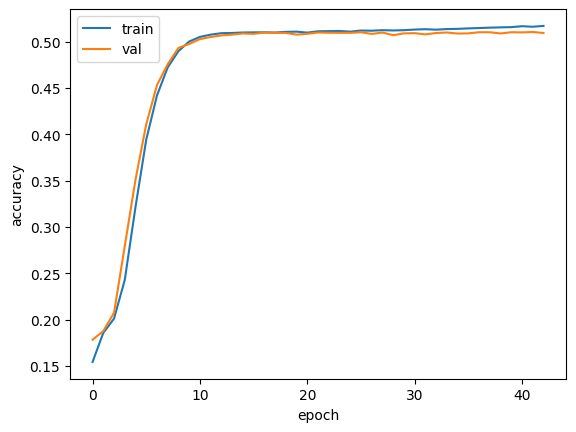

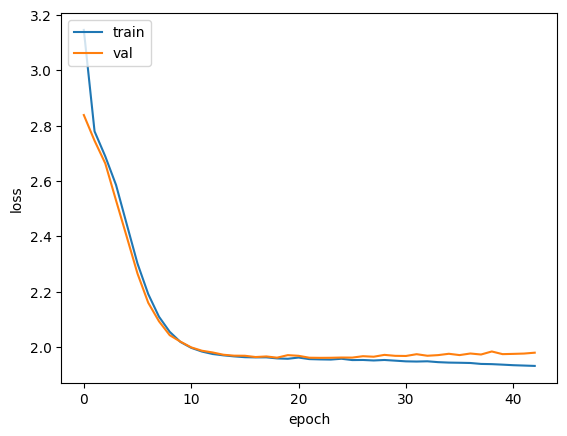

In [24]:
#@title Visualize training and validation LSTM model
visualize_history(history_lstm)

In [25]:
#@title Check random samples LSTM model
check_samples(trained_model_lstm, X_test, y_test, word_array, num_samples=10)

Input: tomato guitar desert Colombo cherry lamp 
Expected: lamp cherry Colombo desert guitar tomato 
Predicted: tomato lion desert desert guitar tomato 
False

Input: desert Tokyo tomato banana cat daisy 
Expected: daisy cat banana tomato Tokyo desert 
Predicted: desert lion Tokyo tomato Tokyo desert 
False

Input: Sydney car rose green violin table 
Expected: table violin green rose car Sydney 
Predicted: Sydney bicycle sunflower rose car Sydney 
False

Input: strawberry Tokyo Colombo chair yellow piano 
Expected: piano yellow chair Colombo Tokyo strawberry 
Predicted: strawberry bicycle Colombo Colombo Tokyo strawberry 
False

Input: mountain banana chair strawberry desert London 
Expected: London desert strawberry chair banana mountain 
Predicted: mountain tulip piano chair banana mountain 
False

Input: dog bus elephant lion chair Sydney 
Expected: Sydney chair lion elephant bus dog 
Predicted: dog broccoli broccoli elephant bus dog 
False

Input: park table violin Tokyo London lam

#3. Information Sharing in RNN Layers

#3.1. LSTM model - Only last hidden state



Model: "model_LSTM_with_last_hidden"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                29440     
                                                                 
 repeat_vector (RepeatVecto  (None, 6, 64)             0         
 r)                                                              
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 repeat_vector_1 (RepeatVec  (None, 6, 64)             0         
 tor)                                                            
                                                                 
 dense_6 (Dense)             (None, 6, 50)             3250      
                                                                 
Total params: 65714 (256.70 KB)
Trainab

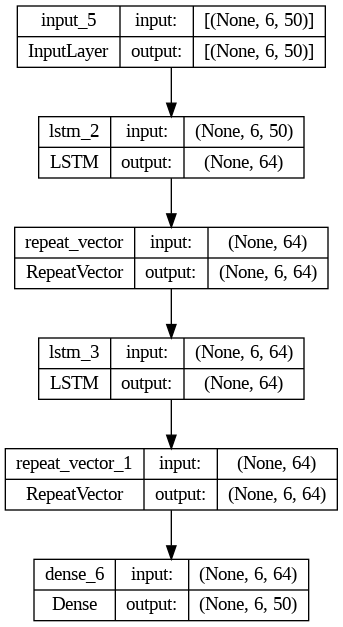

In [26]:
#@title Create LSTM model with only last hidden state
numberOfUnits = 64
model_LSTM_with_last_hidden = Sequential(name='model_LSTM_with_last_hidden')
model_LSTM_with_last_hidden.add(Input(shape=(n_timesteps_in, n_features)))
model_LSTM_with_last_hidden.add(LSTM(numberOfUnits))
model_LSTM_with_last_hidden.add(RepeatVector(n_timesteps_in))
model_LSTM_with_last_hidden.add(LSTM(numberOfUnits))
model_LSTM_with_last_hidden.add(RepeatVector(n_timesteps_in))
model_LSTM_with_last_hidden.add(Dense(n_features, activation='softmax'))


model_LSTM_with_last_hidden.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_LSTM_with_last_hidden.summary()
plot_model(model_LSTM_with_last_hidden,show_shapes=True)

In [27]:
#@title Train and Evaluate LSTM model with only last hidden state
trained_model_with_last_hidden, history_with_last_hidden = train_test(model_LSTM_with_last_hidden, X_train, y_train , X_test, y_test, verbose=2)

training for  100  epochs begins with validation_split= 0.1 & EarlyStopping(monitor= val_loss, patience=20)....
Epoch 1/100
563/563 - 11s - loss: 2.8206 - accuracy: 0.1862 - val_loss: 2.4184 - val_accuracy: 0.2100 - 11s/epoch - 19ms/step
Epoch 2/100
563/563 - 6s - loss: 2.2999 - accuracy: 0.2115 - val_loss: 2.2174 - val_accuracy: 0.2110 - 6s/epoch - 11ms/step
Epoch 3/100
563/563 - 5s - loss: 2.1360 - accuracy: 0.2118 - val_loss: 2.0911 - val_accuracy: 0.2113 - 5s/epoch - 9ms/step
Epoch 4/100
563/563 - 6s - loss: 2.0368 - accuracy: 0.2117 - val_loss: 2.0156 - val_accuracy: 0.2113 - 6s/epoch - 11ms/step
Epoch 5/100
563/563 - 6s - loss: 1.9720 - accuracy: 0.2115 - val_loss: 1.9625 - val_accuracy: 0.2107 - 6s/epoch - 10ms/step
Epoch 6/100
563/563 - 7s - loss: 1.9267 - accuracy: 0.2113 - val_loss: 1.9214 - val_accuracy: 0.2103 - 7s/epoch - 12ms/step
Epoch 7/100
563/563 - 5s - loss: 1.8931 - accuracy: 0.2112 - val_loss: 1.8934 - val_accuracy: 0.2102 - 5s/epoch - 10ms/step
Epoch 8/100
563/563

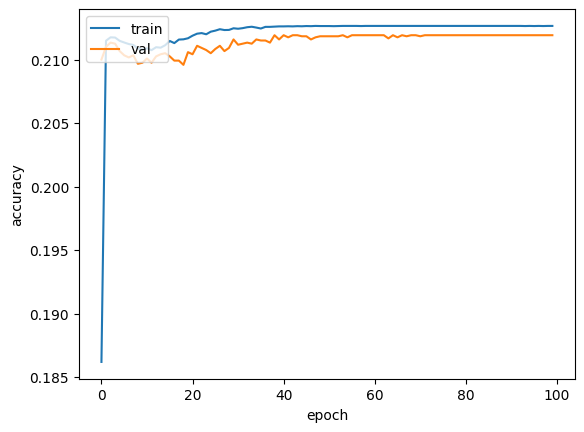

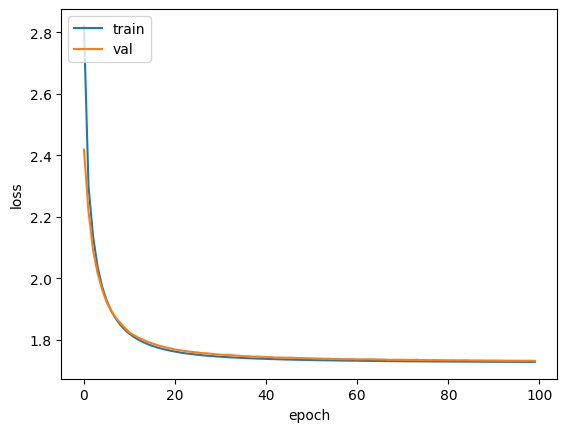

In [28]:
#@title Visualize training and validation LSTM model with only last hidden state
visualize_history(history_with_last_hidden)

In [29]:
#@title Check random samples LSTM model with only last hidden state
check_samples(trained_model_with_last_hidden, X_test, y_test, word_array, num_samples=10)

Input: tomato trumpet yellow chair strawberry rose 
Expected: rose strawberry chair yellow trumpet tomato 
Predicted: yellow yellow yellow yellow yellow yellow 
False

Input: tomato Tokyo rose violin elephant book 
Expected: book elephant violin rose Tokyo tomato 
Predicted: elephant elephant elephant elephant elephant elephant 
False

Input: mountain Paris motorcycle flute bird tulip 
Expected: tulip bird flute motorcycle Paris mountain 
Predicted: motorcycle motorcycle motorcycle motorcycle motorcycle motorcycle 
False

Input: broccoli yellow train Paris red red 
Expected: red red Paris train yellow broccoli 
Predicted: red red red red red red 
False

Input: beach bicycle chair lily green desert 
Expected: desert green lily chair bicycle beach 
Predicted: desert desert desert desert desert desert 
False

Input: elephant cucumber flute apple daisy cherry 
Expected: cherry daisy apple flute cucumber elephant 
Predicted: elephant elephant elephant elephant elephant elephant 
False

Inpu

#3.2. LSTM model - Last hidden state and last cell state

Model: "model_LSTM_with_last_hidden_and_last_cell"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 6, 50)]              0         []                            
                                                                                                  
 lstm_4 (LSTM)               [(None, 64),                 29440     ['input_6[0][0]']             
                              (None, 64),                                                         
                              (None, 64)]                                                         
                                                                                                  
 repeat_vector_2 (RepeatVec  (None, 6, 64)                0         ['lstm_4[0][0]']              
 tor)                                                     

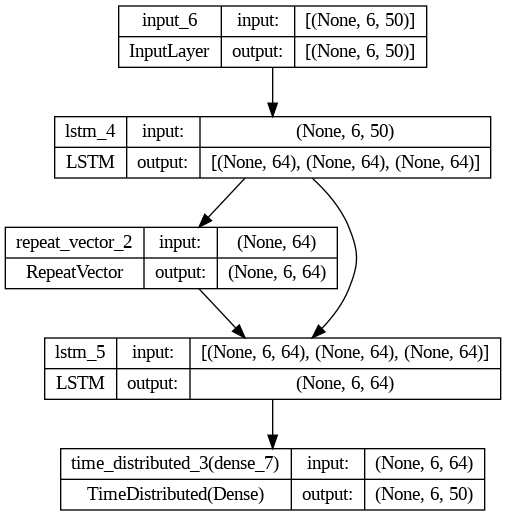

In [30]:
#@title Create LSTM model with last hidden state and last cell state
numberOfUnits = 64
input= Input(shape=(n_timesteps_in, n_features))

lstm1 = LSTM(numberOfUnits,return_state=True)
LSTM_output, state_h, state_c = lstm1(input)
states = [state_h, state_c]

repeat=RepeatVector(n_timesteps_in)
LSTM_output = repeat(LSTM_output)

lstm2 = LSTM(numberOfUnits,return_sequences=True)
all_state_h = lstm2(LSTM_output,initial_state=states)

dense = TimeDistributed(Dense(n_features, activation='softmax'))
output = dense(all_state_h)
model_LSTM_with_last_hidden_and_last_cell = Model(input,output,name='model_LSTM_with_last_hidden_and_last_cell')
model_LSTM_with_last_hidden_and_last_cell.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_LSTM_with_last_hidden_and_last_cell.summary()
plot_model(model_LSTM_with_last_hidden_and_last_cell,show_shapes=True)

In [31]:
#@title Train and Evaluate LSTM model with last hidden state and last cell state
trained_model_with_last_hidden_and_last_cell, history_with_last_hidden_and_last_cell = train_test(model_LSTM_with_last_hidden_and_last_cell, X_train, y_train , X_test, y_test, verbose=2)

training for  100  epochs begins with validation_split= 0.1 & EarlyStopping(monitor= val_loss, patience=20)....
Epoch 1/100
563/563 - 12s - loss: 2.8439 - accuracy: 0.1910 - val_loss: 2.4004 - val_accuracy: 0.2360 - 12s/epoch - 22ms/step
Epoch 2/100
563/563 - 6s - loss: 2.1674 - accuracy: 0.2851 - val_loss: 1.9639 - val_accuracy: 0.3453 - 6s/epoch - 11ms/step
Epoch 3/100
563/563 - 6s - loss: 1.7441 - accuracy: 0.4096 - val_loss: 1.5974 - val_accuracy: 0.4558 - 6s/epoch - 11ms/step
Epoch 4/100
563/563 - 6s - loss: 1.4204 - accuracy: 0.5111 - val_loss: 1.3343 - val_accuracy: 0.5508 - 6s/epoch - 11ms/step
Epoch 5/100
563/563 - 6s - loss: 1.1633 - accuracy: 0.6044 - val_loss: 1.1010 - val_accuracy: 0.6343 - 6s/epoch - 11ms/step
Epoch 6/100
563/563 - 7s - loss: 0.9548 - accuracy: 0.6829 - val_loss: 0.9148 - val_accuracy: 0.6998 - 7s/epoch - 12ms/step
Epoch 7/100
563/563 - 6s - loss: 0.7878 - accuracy: 0.7453 - val_loss: 0.7689 - val_accuracy: 0.7514 - 6s/epoch - 11ms/step
Epoch 8/100
563/56

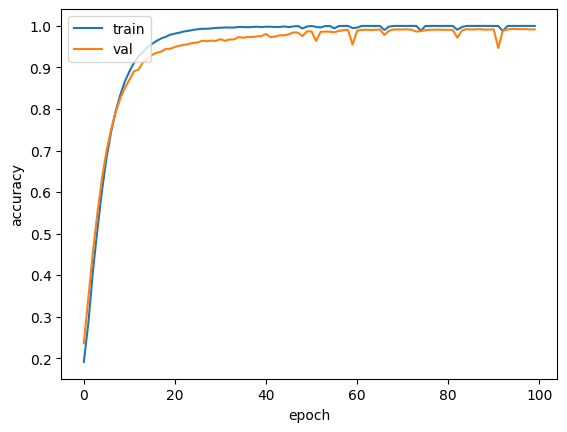

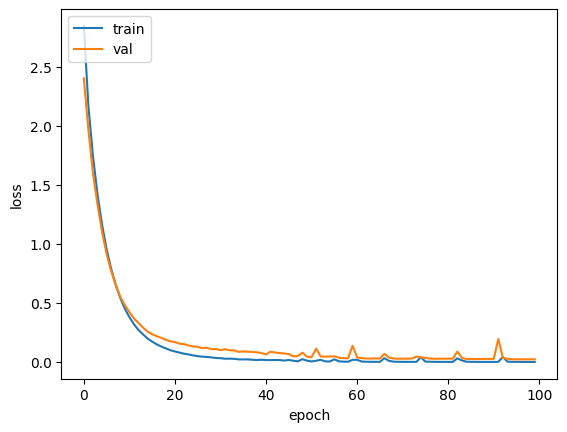

In [32]:
#@title Visualize training and validation LSTM model with last hidden state and last cell state
visualize_history(history_with_last_hidden_and_last_cell)

In [33]:
#@title Check random samples LSTM model with last hidden state and last cell state
check_samples(trained_model_with_last_hidden_and_last_cell, X_test, y_test, word_array, num_samples=10)

Input: tulip orange bus trumpet table rose 
Expected: rose table trumpet bus orange tulip 
Predicted: rose table trumpet bus orange tulip 
True

Input: tulip apple elephant daisy blue green 
Expected: green blue daisy elephant apple tulip 
Predicted: green blue daisy elephant apple tulip 
True

Input: elephant cucumber flute apple daisy cherry 
Expected: cherry daisy apple flute cucumber elephant 
Predicted: cherry daisy apple flute cucumber elephant 
True

Input: park bird guitar orange guitar potato 
Expected: potato guitar orange guitar bird park 
Predicted: potato guitar orange guitar bird park 
True

Input: train beach train lion motorcycle lion 
Expected: lion motorcycle lion train beach train 
Predicted: lion motorcycle lion train beach train 
True

Input: daisy violin apple car orange chair 
Expected: chair orange car apple violin daisy 
Predicted: chair orange car apple violin daisy 
True

Input: Tokyo beach lily violin guitar banana 
Expected: banana guitar violin lily beach 

#3.3. LSTM model - All hidden states and last cell state

Model: "model_LSTM_with_all_hidden_and_last_cell"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 6, 50)]              0         []                            
                                                                                                  
 lstm_6 (LSTM)               [(None, 6, 64),              29440     ['input_7[0][0]']             
                              (None, 64),                                                         
                              (None, 64)]                                                         
                                                                                                  
 lstm_7 (LSTM)               (None, 6, 64)                33024     ['lstm_6[0][0]',              
                                                           

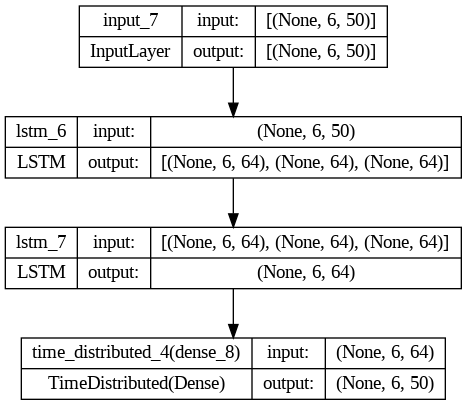

In [34]:
#@title Create LSTM model with all hidden states and last cell state
numberOfUnits = 64
input= Input(shape=(n_timesteps_in, n_features))

lstm1 = LSTM(numberOfUnits,return_sequences=True, return_state=True)
all_state_h, state_h, state_c = lstm1(input)
states = [state_h, state_c]

lstm2 = LSTM(numberOfUnits,return_sequences=True)
all_state_h = lstm2(all_state_h,initial_state=states)

dense = TimeDistributed(Dense(n_features, activation='softmax'))
output = dense(all_state_h)
model_LSTM_with_all_hidden_and_last_cell = Model(input,output, name='model_LSTM_with_all_hidden_and_last_cell')
model_LSTM_with_all_hidden_and_last_cell.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_LSTM_with_all_hidden_and_last_cell.summary()
plot_model(model_LSTM_with_all_hidden_and_last_cell,show_shapes=True)

In [35]:
#@title Train and Evaluate LSTM model with all hidden states and last cell state
trained_model_with_all_hidden_and_last_cell, history_with_all_hidden_and_last_cell = train_test(model_LSTM_with_all_hidden_and_last_cell, X_train, y_train , X_test, y_test, verbose=2)

training for  100  epochs begins with validation_split= 0.1 & EarlyStopping(monitor= val_loss, patience=20)....
Epoch 1/100
563/563 - 12s - loss: 2.8688 - accuracy: 0.1925 - val_loss: 2.3870 - val_accuracy: 0.2449 - 12s/epoch - 21ms/step
Epoch 2/100
563/563 - 7s - loss: 2.1048 - accuracy: 0.3069 - val_loss: 1.8707 - val_accuracy: 0.3736 - 7s/epoch - 12ms/step
Epoch 3/100
563/563 - 6s - loss: 1.6598 - accuracy: 0.4264 - val_loss: 1.5124 - val_accuracy: 0.4765 - 6s/epoch - 10ms/step
Epoch 4/100
563/563 - 7s - loss: 1.3335 - accuracy: 0.5348 - val_loss: 1.2215 - val_accuracy: 0.5804 - 7s/epoch - 12ms/step
Epoch 5/100
563/563 - 6s - loss: 1.0621 - accuracy: 0.6381 - val_loss: 0.9769 - val_accuracy: 0.6737 - 6s/epoch - 10ms/step
Epoch 6/100
563/563 - 7s - loss: 0.8386 - accuracy: 0.7279 - val_loss: 0.8002 - val_accuracy: 0.7383 - 7s/epoch - 12ms/step
Epoch 7/100
563/563 - 6s - loss: 0.6715 - accuracy: 0.7898 - val_loss: 0.6597 - val_accuracy: 0.7907 - 6s/epoch - 10ms/step
Epoch 8/100
563/56

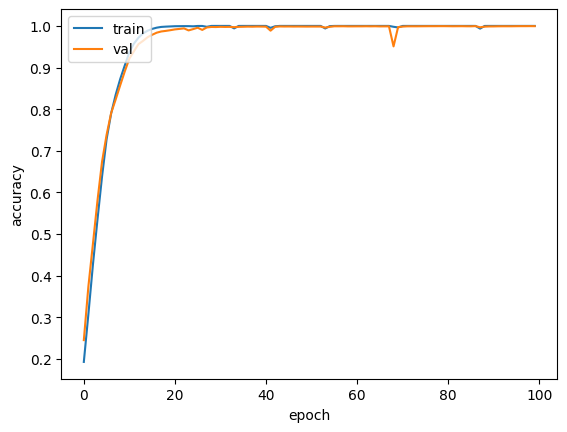

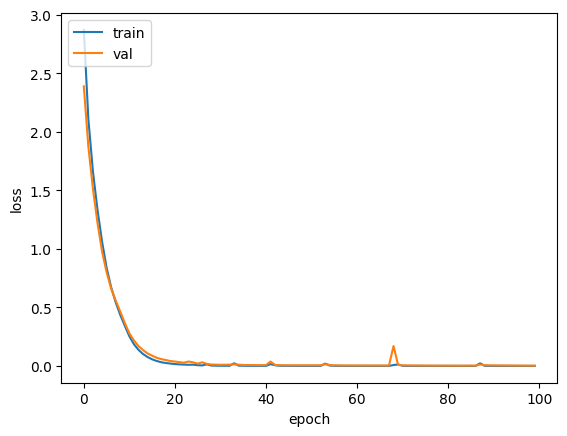

In [36]:
#@title Visualize training and validation LSTM model with all hidden states and last cell state
visualize_history(history_with_all_hidden_and_last_cell)

In [37]:
#@title Check random samples LSTM model with all hidden states and last cell state
check_samples(trained_model_with_all_hidden_and_last_cell, X_test, y_test, word_array, num_samples=10)

Input: mountain Paris motorcycle flute bird tulip 
Expected: tulip bird flute motorcycle Paris mountain 
Predicted: tulip bird flute motorcycle Paris mountain 
True

Input: apple Paris car orange flute car 
Expected: car flute orange car Paris apple 
Predicted: car flute orange car Paris apple 
True

Input: sunflower mountain tulip yellow bus park 
Expected: park bus yellow tulip mountain sunflower 
Predicted: park bus yellow tulip mountain sunflower 
True

Input: piano lily violin island island car 
Expected: car island island violin lily piano 
Predicted: car island island violin lily piano 
True

Input: Paris train park car cat Paris 
Expected: Paris cat car park train Paris 
Predicted: Paris cat car park train Paris 
True

Input: Tokyo lion bus Paris lamp Sydney 
Expected: Sydney lamp Paris bus lion Tokyo 
Predicted: Sydney lamp Paris bus lion Tokyo 
True

Input: strawberry cat park table Sydney trumpet 
Expected: trumpet Sydney table park cat strawberry 
Predicted: trumpet Sydney 

#Reference
1. https://www.muratkarakaya.net/2022/11/seq2seq-learning-tutorial-series.html
2. https://deeplearningmath.org/sequence-models.html
